$(0,1)$
- Differences: $21<x2<131, 94<x1<308$ (22 instances)
- R: $x2>21, x1>-34$
    - CF: $x2≤21 \rightarrow (0,0)$
    - RL: $x2≤131, x1≥94$
        - CF: $x2≥189 \rightarrow (1,1)$
        - CF: $x1≤81 \rightarrow (1,1)$
        - RLL: $x2≥78, x1≥207$ (6 instances different)
            - CF: $x2≥146 \rightarrow (1,1)$
            - CF: $x1≤158 \rightarrow (1,1)$
        - RLR: $x2≤71$ (16 instances different)

$(1,0)$
- Differences: $-28<x2<20, -44<x1<63$ (15 instances)
- R: $x2<20$
    - CF: $x2≥22 \rightarrow (1,1)$
    - RL: $x2≥-28, -44<x1<63$
        - CF: $x2≤-71 \rightarrow (0,0)$
        - CF: $x1≤-17 \rightarrow (0,0)$
        - CF: $x1≥78 \rightarrow (0,0)$
        - RLL: $x2≥11, x1≥-13$ (5 instances different)
            - CF: $x2≤-49 \rightarrow (0,0)$
        - RLR: $x2<-3, x1<32$ (10 instances different)
            - CF: $x1≥48 \rightarrow (0,0)$

In [1]:
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering
from tasks.feature_ignored import make_task
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [6]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [4]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='proba')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='proba')
with open('indiv.proba.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.proba.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6.3 s, sys: 126 ms, total: 6.43 s
Wall time: 6.83 s


# Traditional SHAP Explanations

In [5]:
with open('indiv.proba.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [6]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

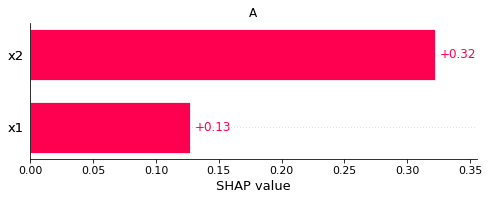

In [7]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

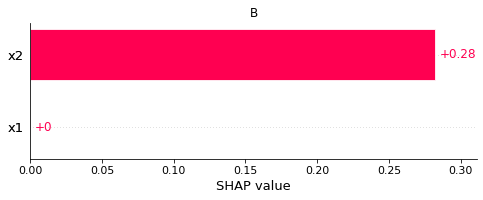

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [11]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 27.7 ms, sys: 3.14 ms, total: 30.8 ms
Wall time: 33.2 ms


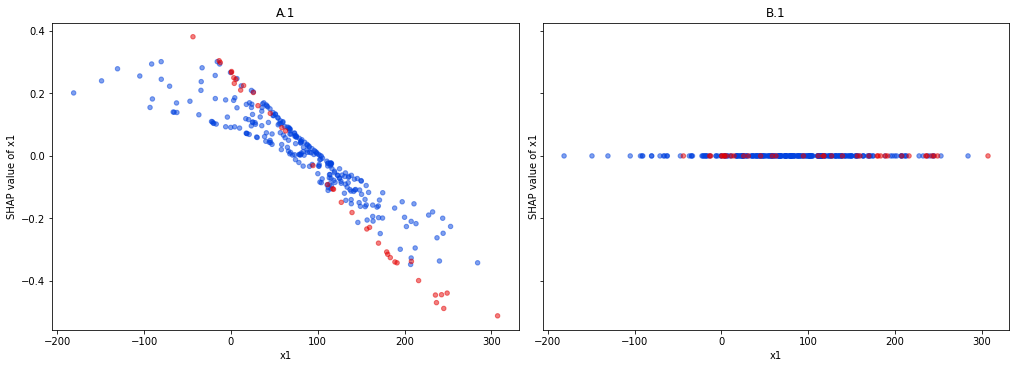

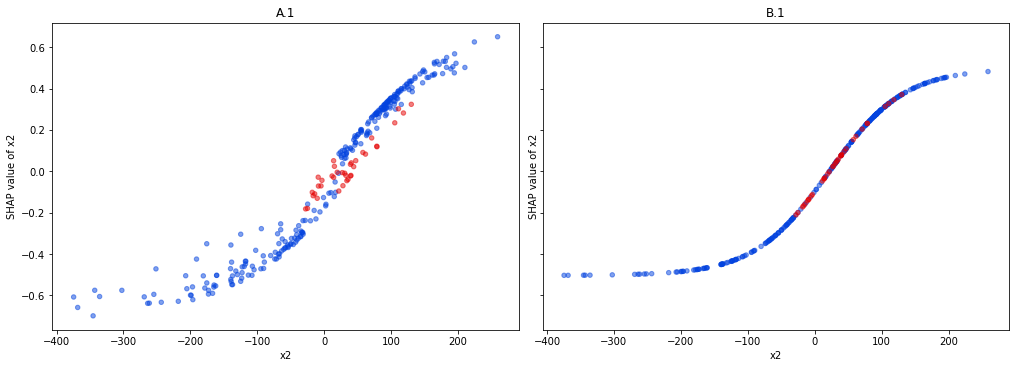

In [12]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [14]:
with open('diffclf.proba.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

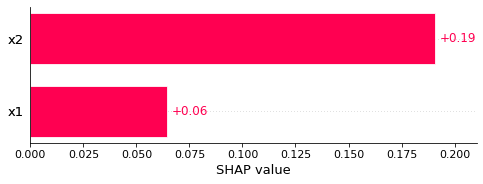

In [15]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

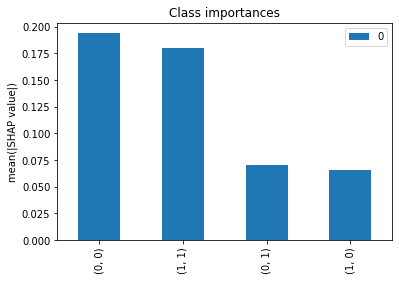

In [17]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [18]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'])
node.distance, node.class_counts

CPU times: user 213 ms, sys: 6.4 ms, total: 219 ms
Wall time: 233 ms


(2.8589551366957586,
 (1, 1)    149
 (0, 0)    114
 (0, 1)     22
 (1, 0)     15
 dtype: int64)

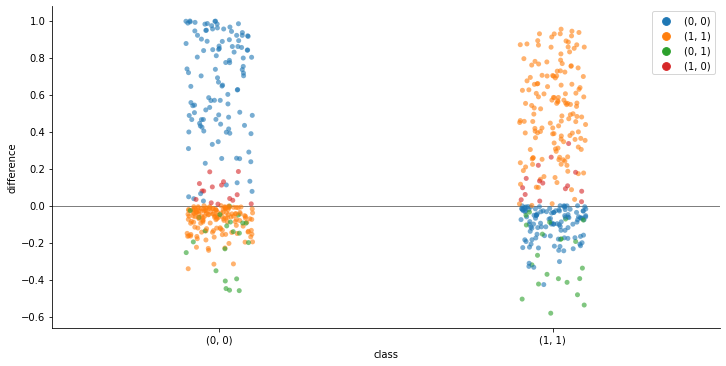

{'(0, 0)': '-0.46 to -0.0', '(1, 1)': '-0.58 to -0.04'}


In [14]:
node.plot_outcome_differences()

### Node R

In [61]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(R,
 (1, 1)    149
 (0, 0)     34
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 1.7585104415387192)

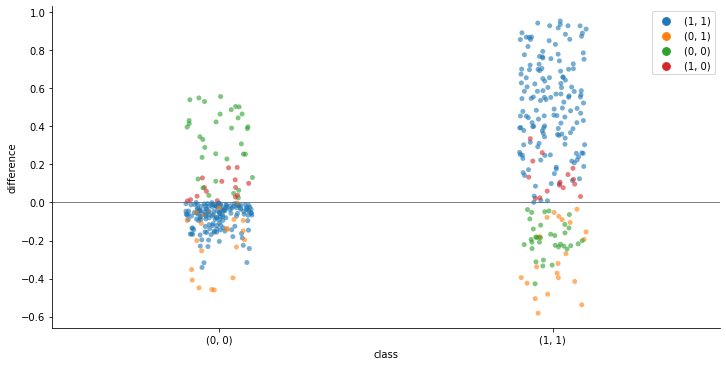

{'(0, 0)': '-0.46 to -0.0', '(1, 1)': '-0.58 to -0.04'}


In [62]:
node.plot_outcome_differences()

94.55361439361346 <= x1
x1 <= 81.0 --> {'(1, 1)': 22}


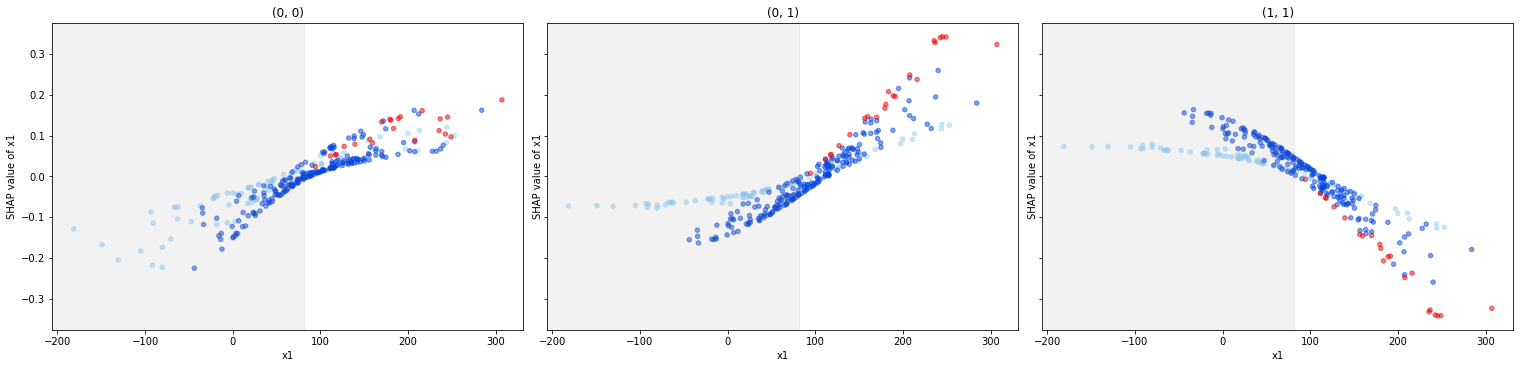

21.71322062603863 <= x2 <= 130.02506989441343
x2 <= 21.0 --> {'(0, 0)': 22}
x2 >= 189.0 --> {'(1, 1)': 22}


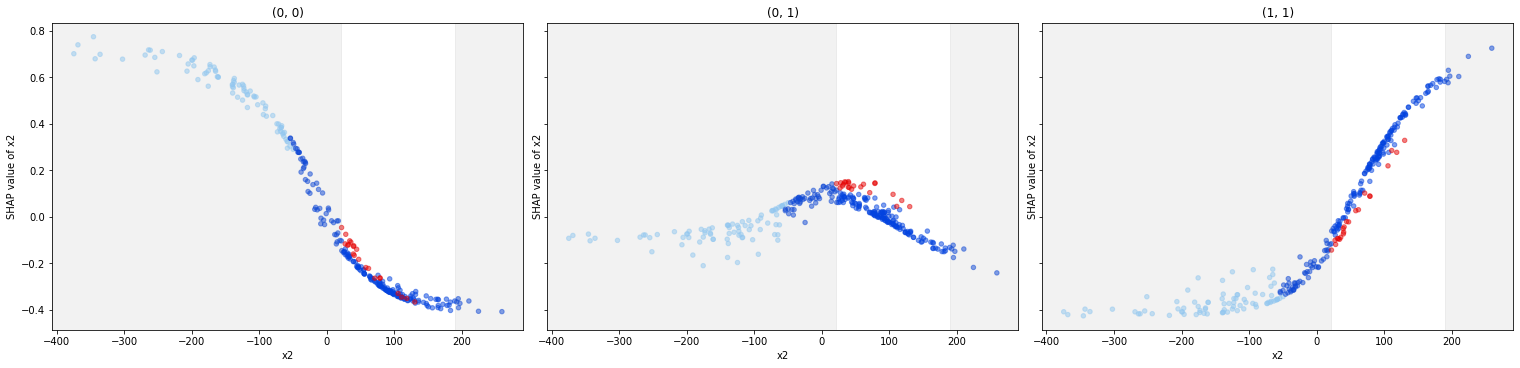

In [63]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

### Node RLRL

In [17]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRL,
 (0, 1)    4
 (1, 1)    2
 dtype: int64,
 0.035411012318173576)

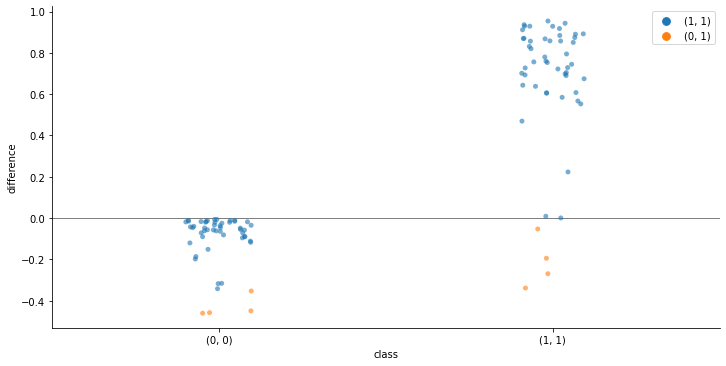

{'(0, 0)': '-0.46 to -0.35', '(1, 1)': '-0.34 to -0.05'}


In [19]:
node.parent.plot_outcome_differences()

207.88011354547447 <= x1 <= 249.04127642882824
x1 <= 194.0 --> {'(1, 1)': 4}


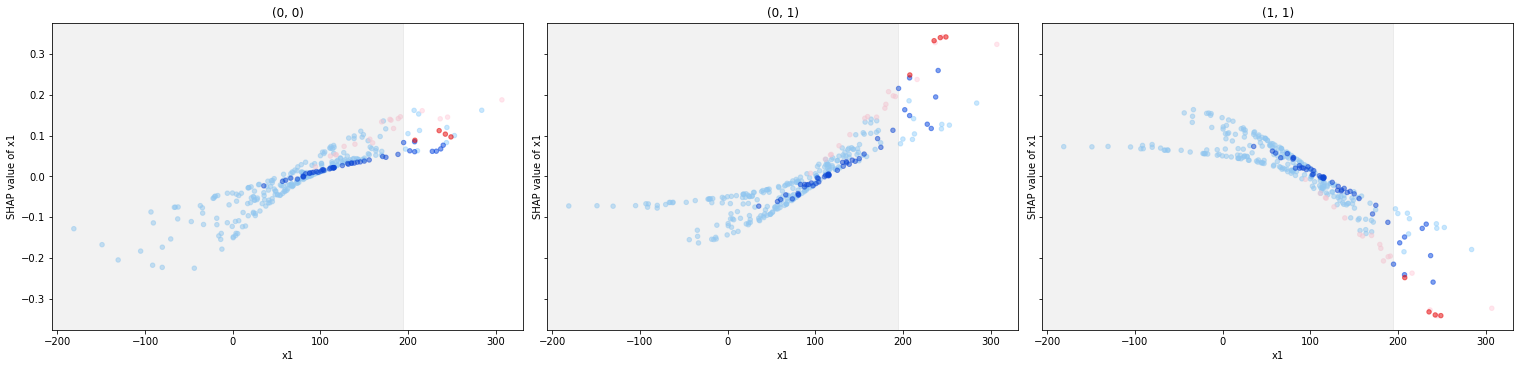

105.35039011208185 <= x2 <= 130.02506989441343
x2 <= 21.0 --> {'(0, 0)': 4}
x2 >= 146.0 --> {'(1, 1)': 4}


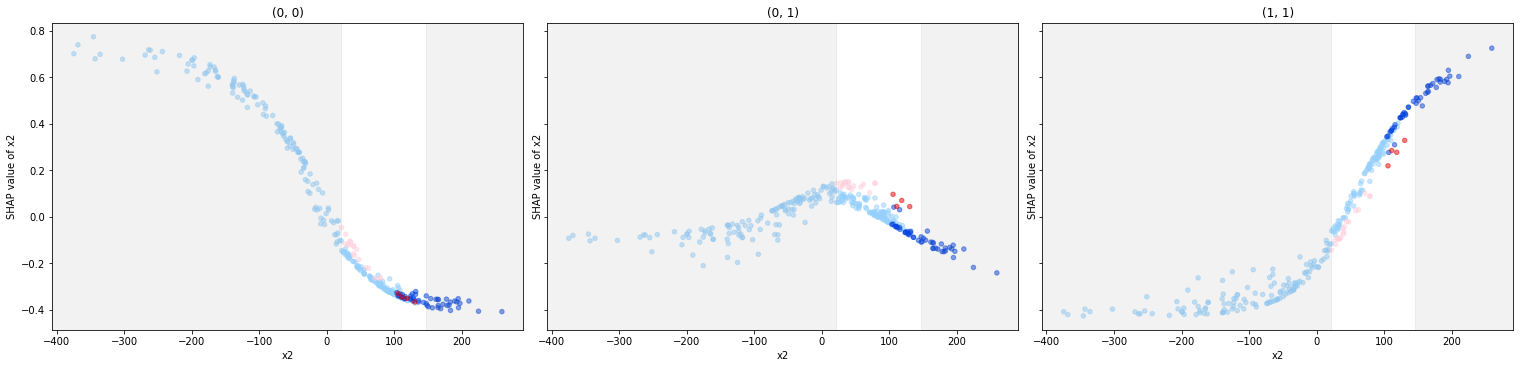

In [20]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.parent, alpha=0.5)

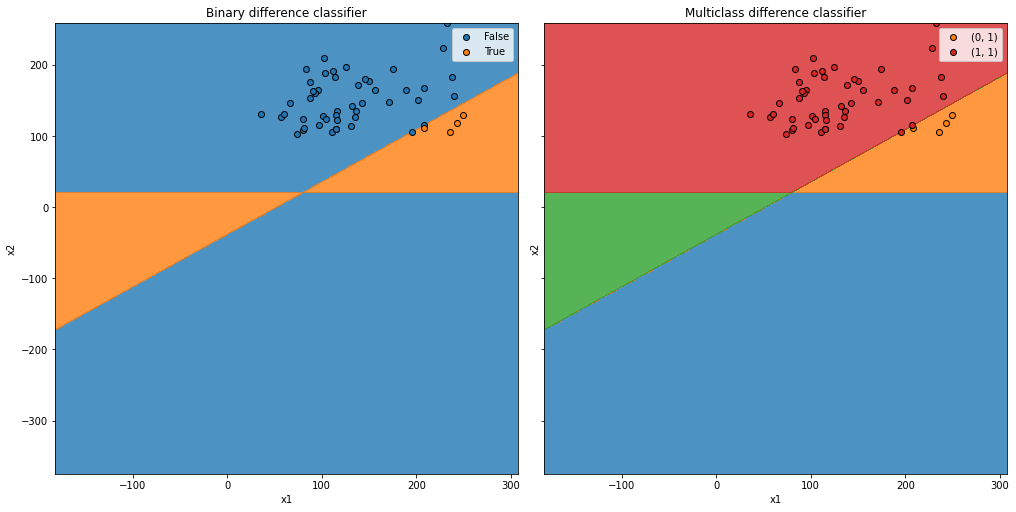

In [21]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim)

### Node RR

In [22]:
node = node.root.get('RR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RR,
 (1, 1)    42
 (0, 0)    34
 (0, 1)    18
 (1, 0)    15
 dtype: int64,
 0.7746417126601399)

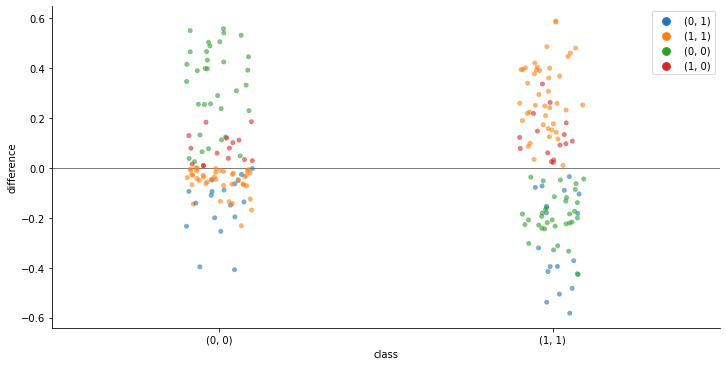

{'(0, 0)': '-0.41 to -0.0', '(1, 1)': '-0.58 to -0.04'}


In [23]:
node.plot_outcome_differences()

94.55361439361346 <= x1
x1 <= 81.0 --> {'(1, 1)': 18}


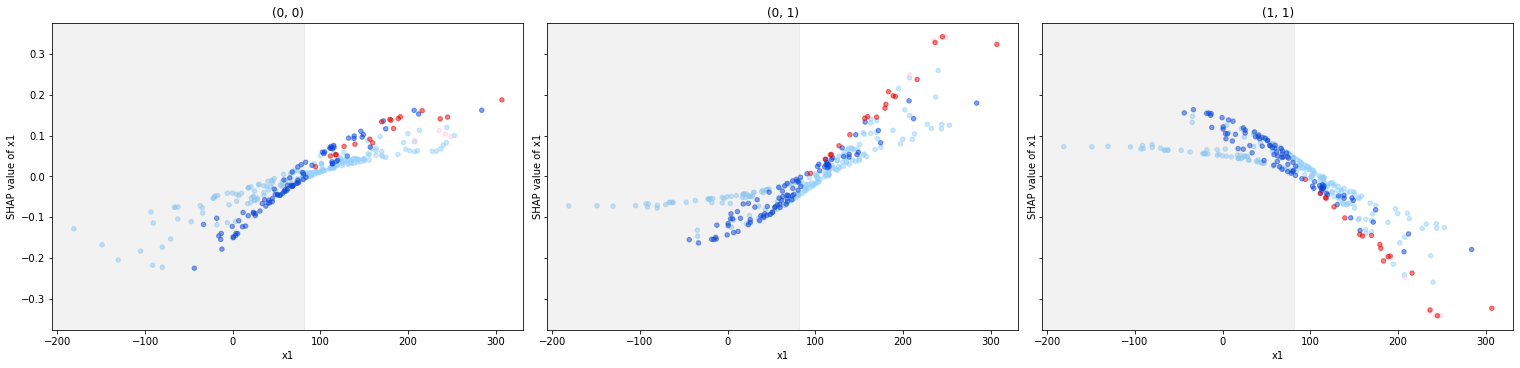

21.71322062603863 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 18}
x2 >= 189.0 --> {'(1, 1)': 18}


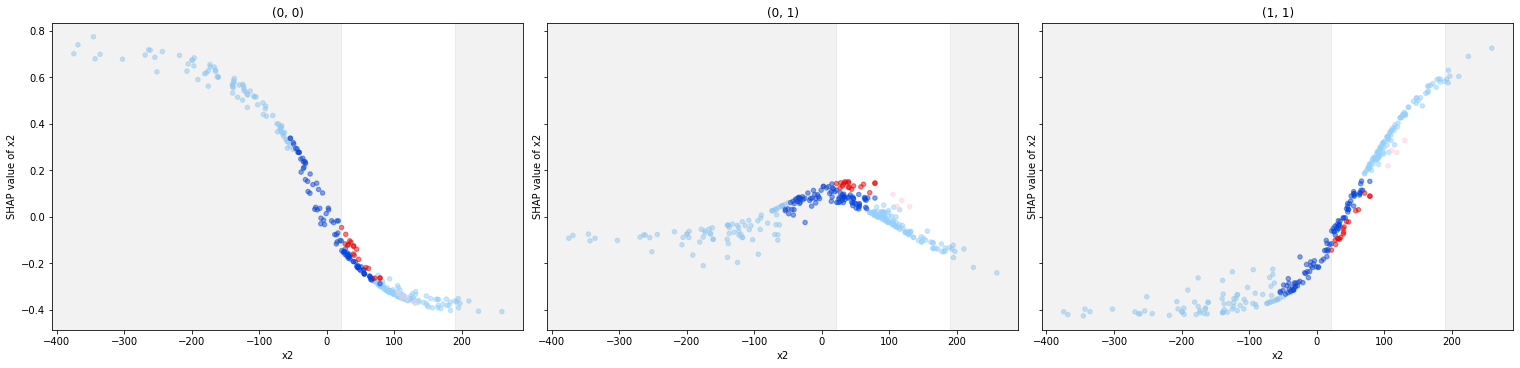

In [24]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

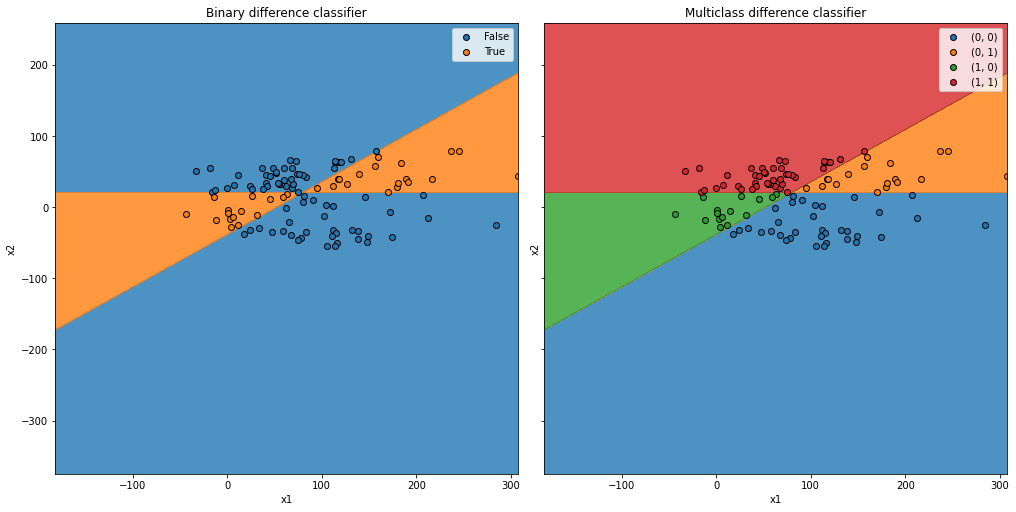

In [25]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRL

In [26]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRL,
 (0, 1)    17
 (1, 1)     7
 (0, 0)     2
 dtype: int64,
 0.24442670711343503)

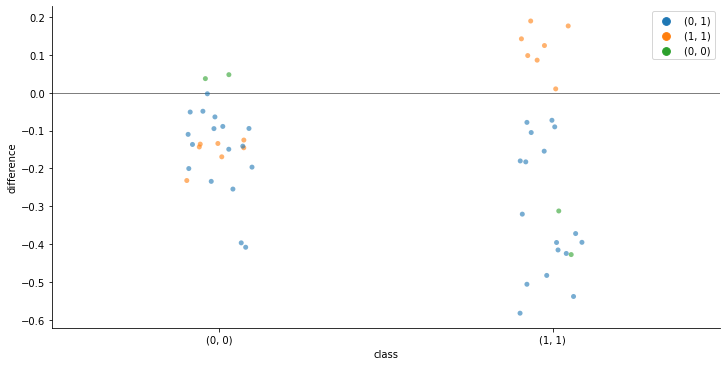

{'(0, 0)': '-0.41 to -0.0', '(1, 1)': '-0.58 to -0.07'}


In [27]:
node.plot_outcome_differences()

111.47492481456109 <= x1
x1 <= 81.0 --> {'(1, 1)': 17}


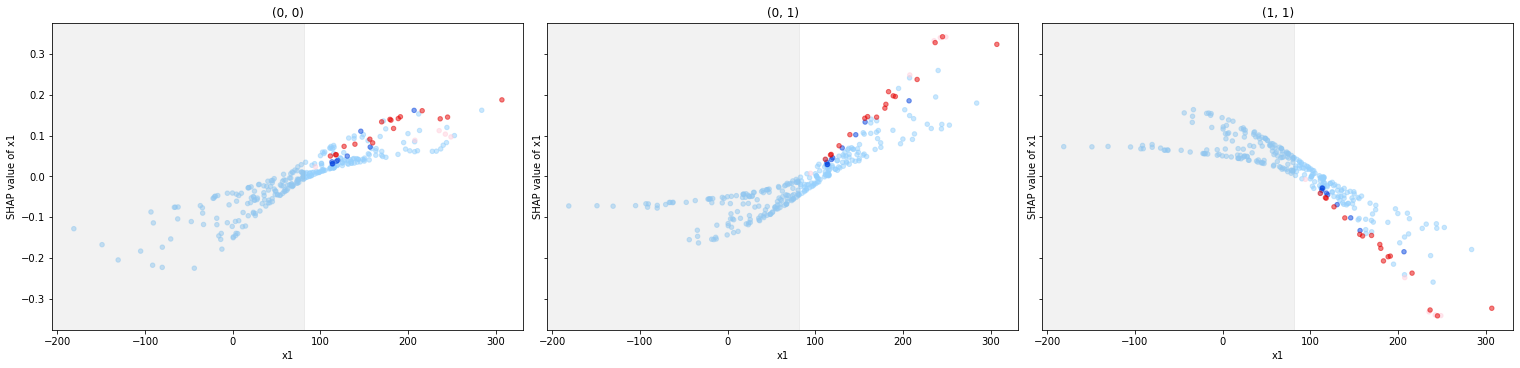

21.71322062603863 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 17}
x2 >= 189.0 --> {'(1, 1)': 17}


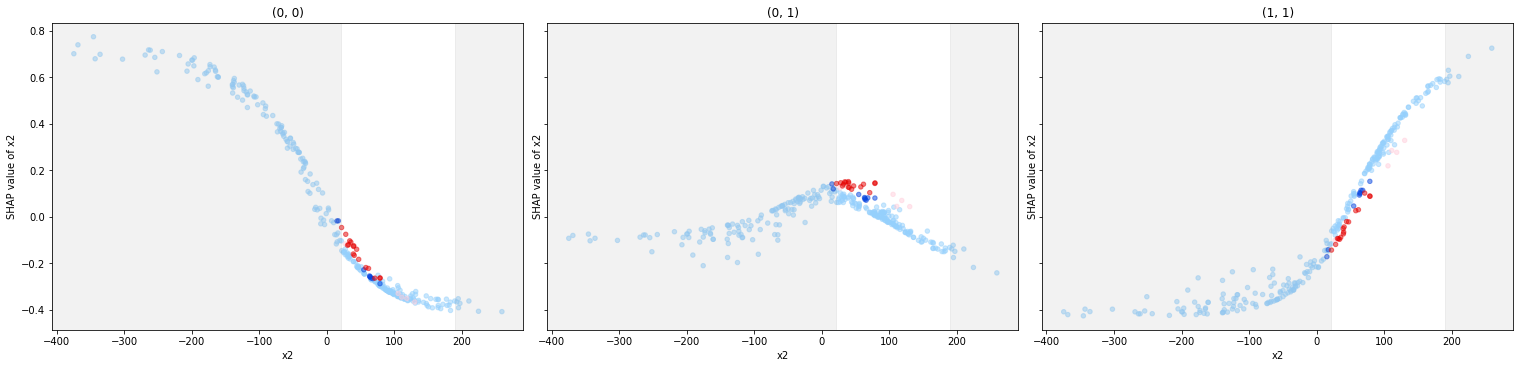

In [28]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

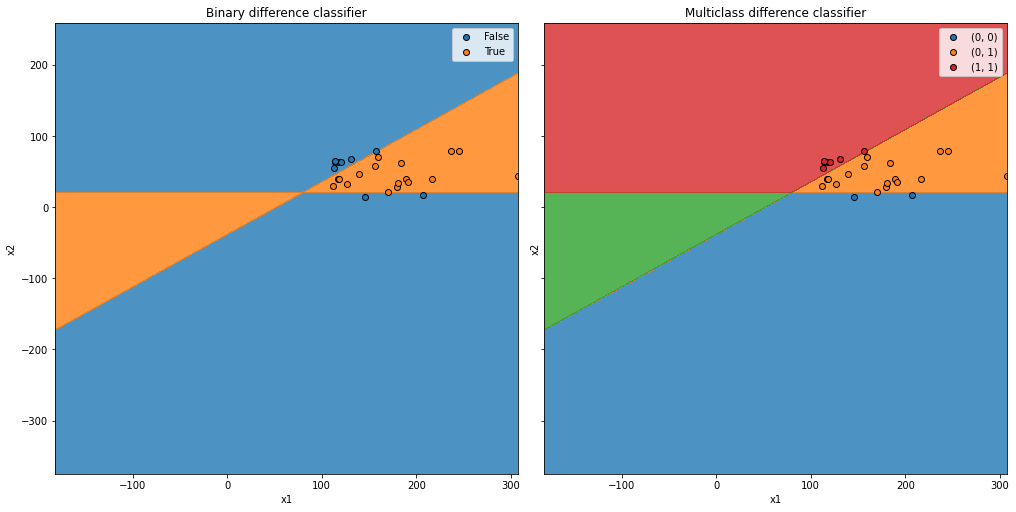

In [29]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLL

In [30]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLL,
 (0, 1)    7
 dtype: int64,
 0.09778921021484234)

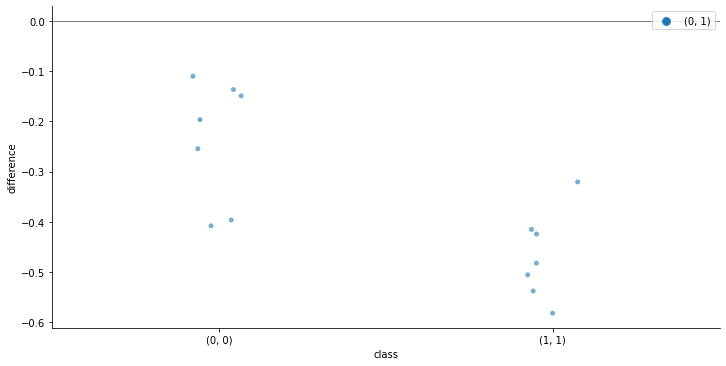

{'(0, 0)': '-0.41 to -0.11', '(1, 1)': '-0.58 to -0.32'}


In [31]:
node.plot_outcome_differences()

183.57246002956597 <= x1
x1 <= 99.0 --> {'(1, 1)': 7}


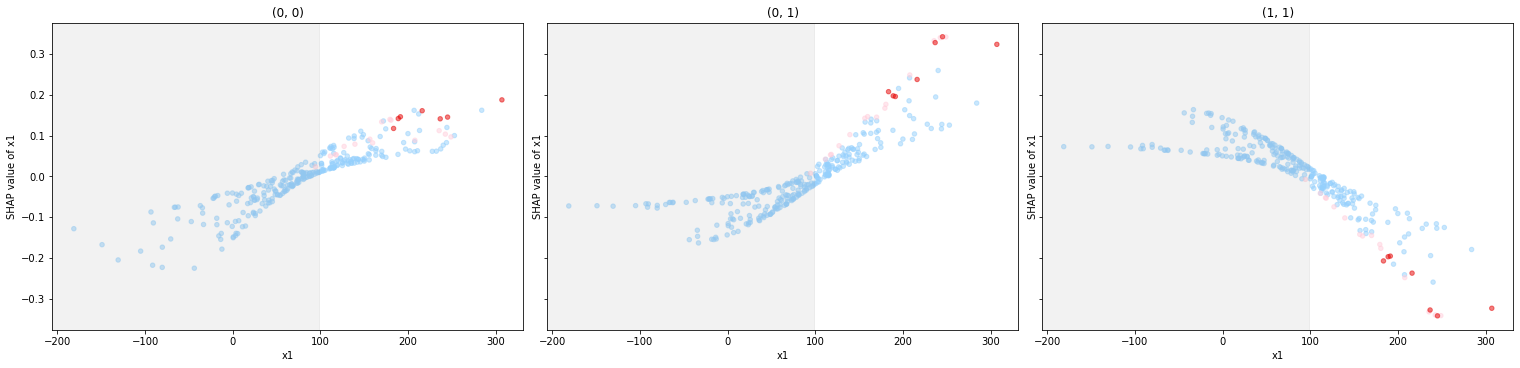

35.47177687927155 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 7}
x2 >= 189.0 --> {'(1, 1)': 7}


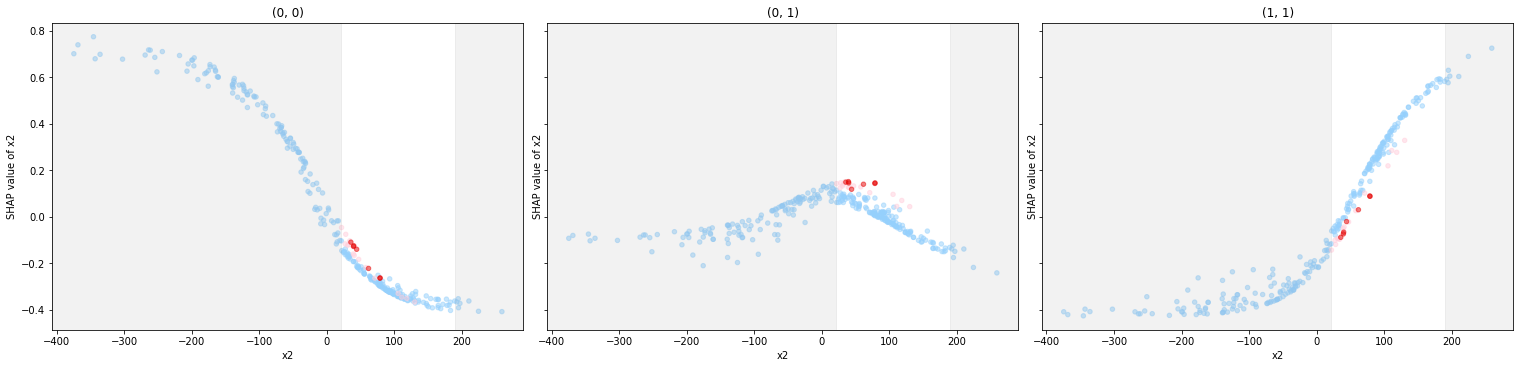

In [32]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

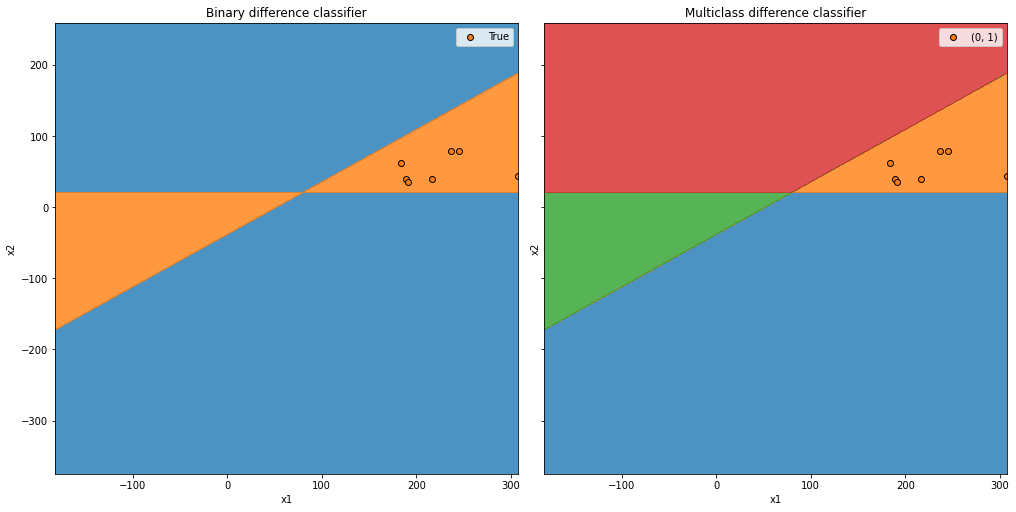

In [33]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLLL

In [51]:
node = node.root.get('RRLLL').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLL,
 (0, 1)    4
 dtype: int64,
 0.027983069407739123)

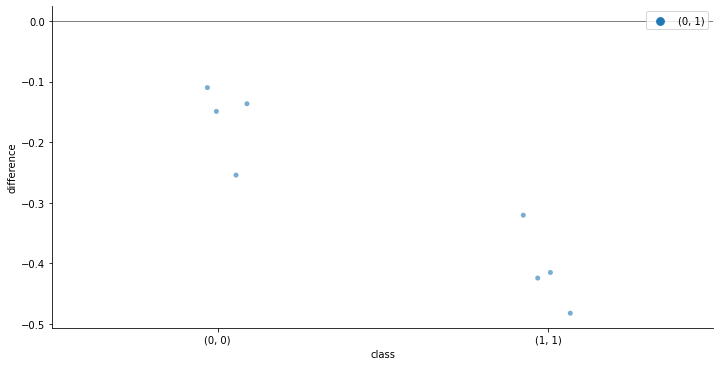

{'(0, 0)': '-0.25 to -0.11', '(1, 1)': '-0.48 to -0.32'}


In [35]:
node.plot_outcome_differences()

183.57246002956597 <= x1 <= 216.1911730686155
x1 <= 99.0 --> {'(1, 1)': 4}


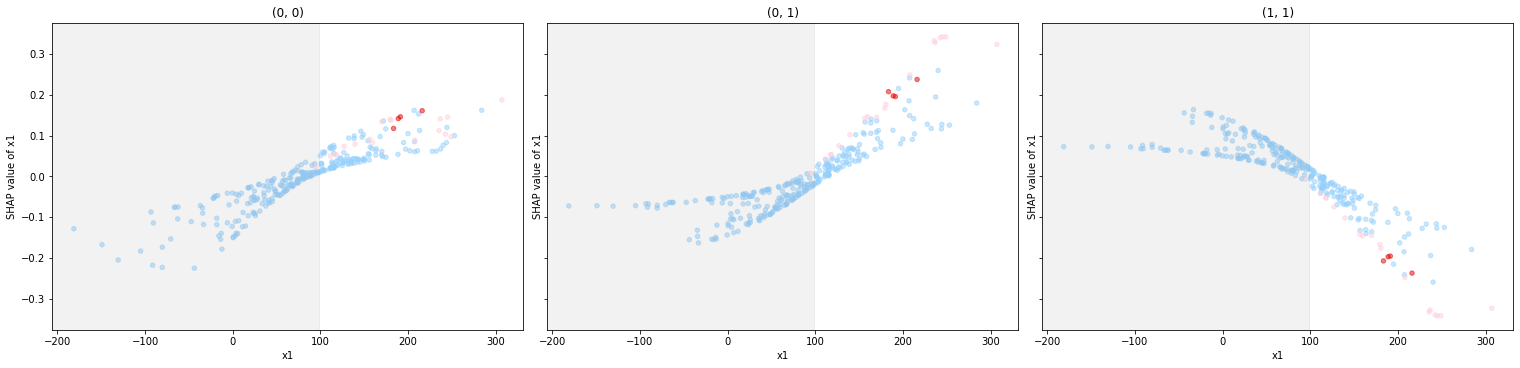

35.47177687927155 <= x2 <= 61.597430976747034
x2 <= 21.0 --> {'(0, 0)': 4}
x2 >= 122.0 --> {'(1, 1)': 4}


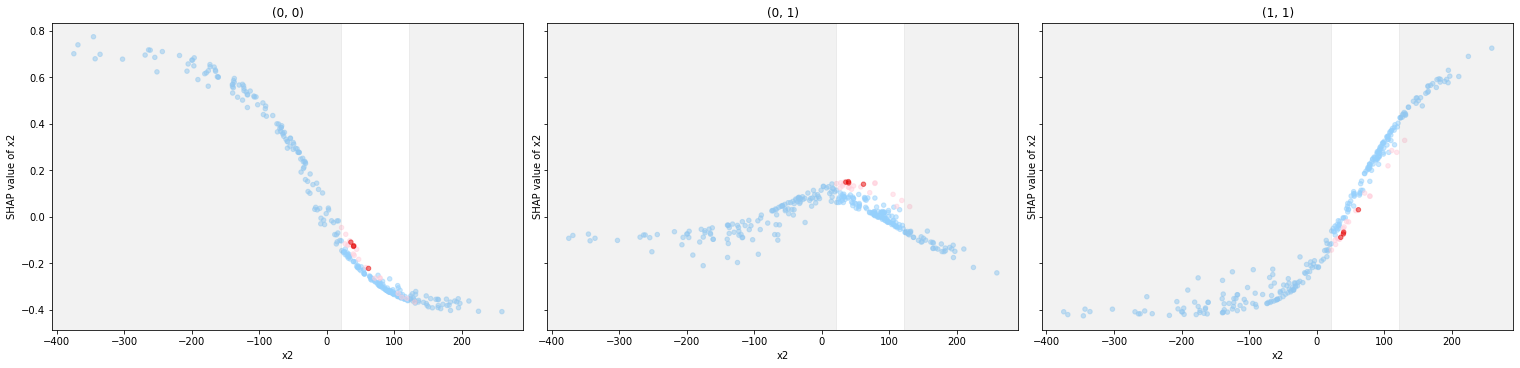

In [36]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

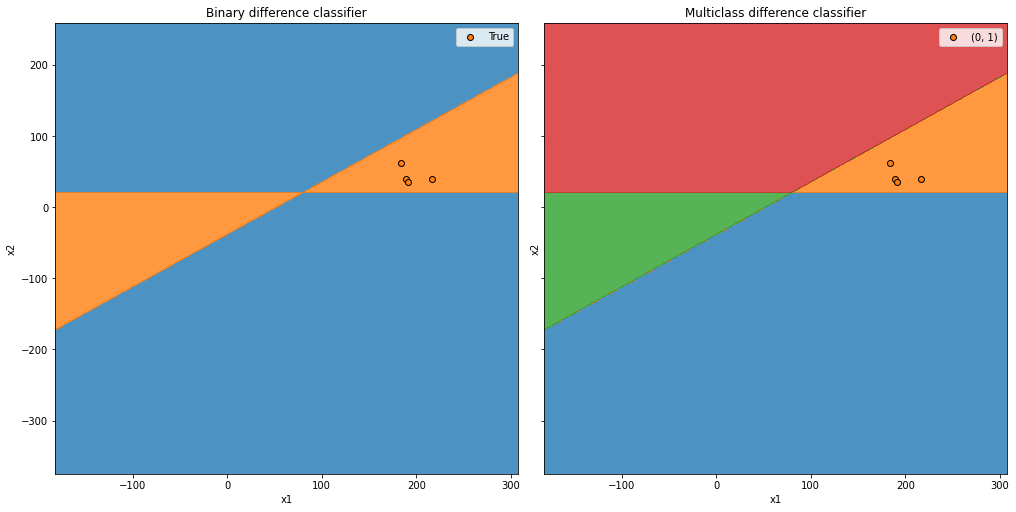

In [37]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLLLL

In [52]:
node = node.root.get('RRLLLL').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLLL,
 (0, 1)    1
 dtype: int64,
 0)

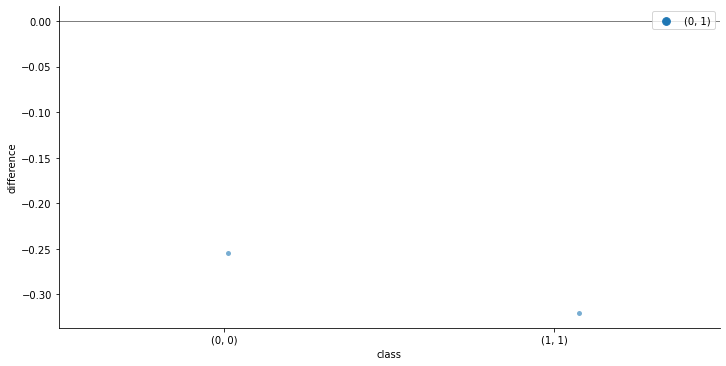

{'(0, 0)': '-0.25 to -0.25', '(1, 1)': '-0.32 to -0.32'}


In [53]:
node.plot_outcome_differences()

x1 == 183.57246002956597
x1 <= 135.0 --> {'(1, 1)': 1}


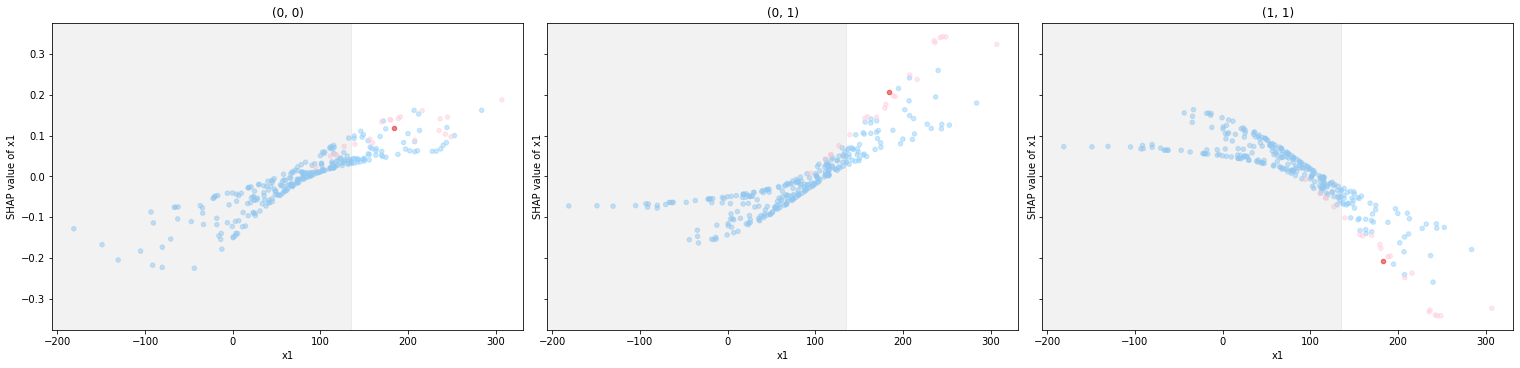

x2 == 61.597430976747034
x2 <= 21.0 --> {'(0, 0)': 1}
x2 >= 98.0 --> {'(1, 1)': 1}


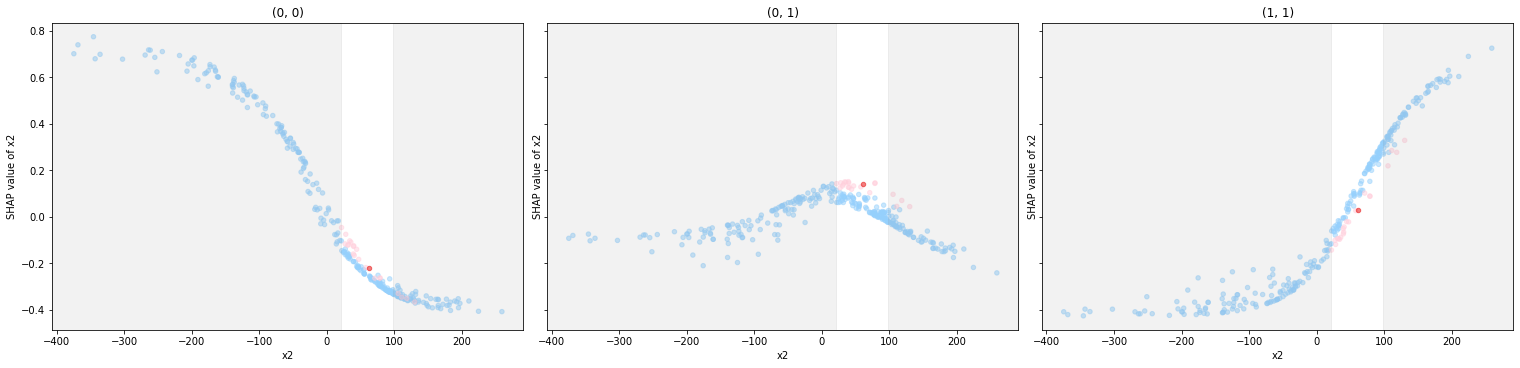

In [54]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

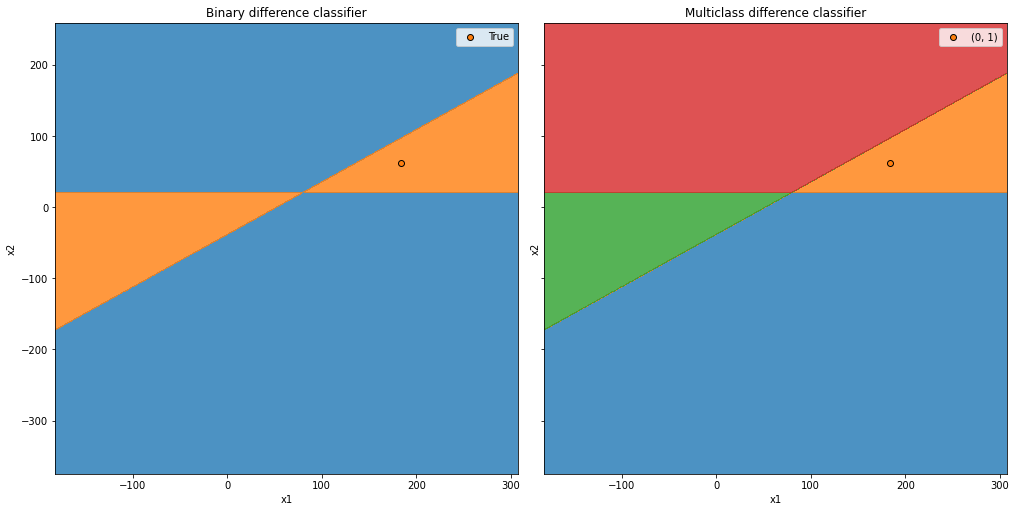

In [55]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLLLR

In [56]:
node = node.root.get('RRLLLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLLR,
 (0, 1)    3
 dtype: int64,
 0.004464605529818543)

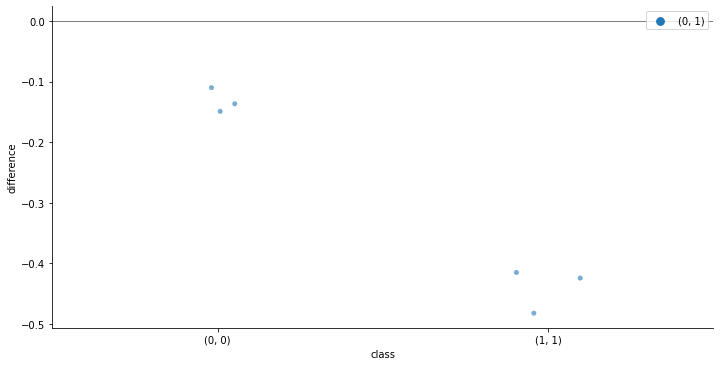

{'(0, 0)': '-0.15 to -0.11', '(1, 1)': '-0.48 to -0.42'}


In [57]:
node.plot_outcome_differences()

188.90234847581414 <= x1 <= 216.1911730686155
x1 <= 99.0 --> {'(1, 1)': 3}


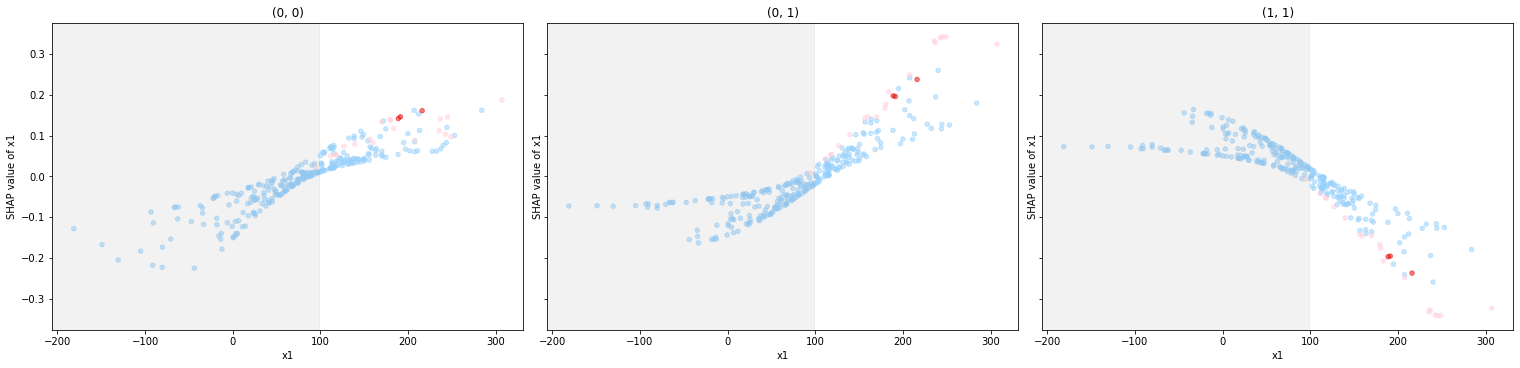

35.47177687927155 <= x2 <= 39.793865327223976
x2 <= 21.0 --> {'(0, 0)': 3}
x2 >= 122.0 --> {'(1, 1)': 3}


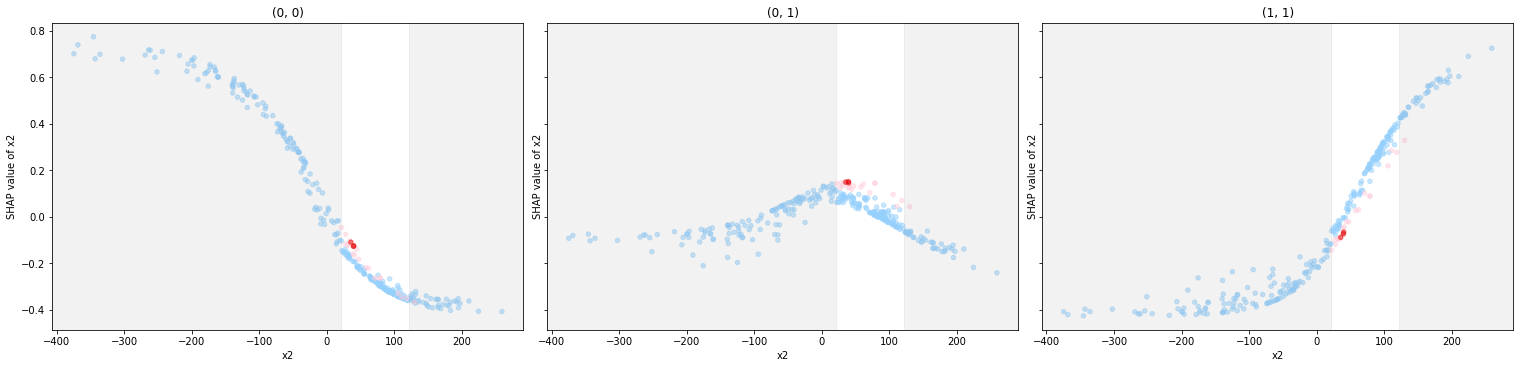

In [58]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

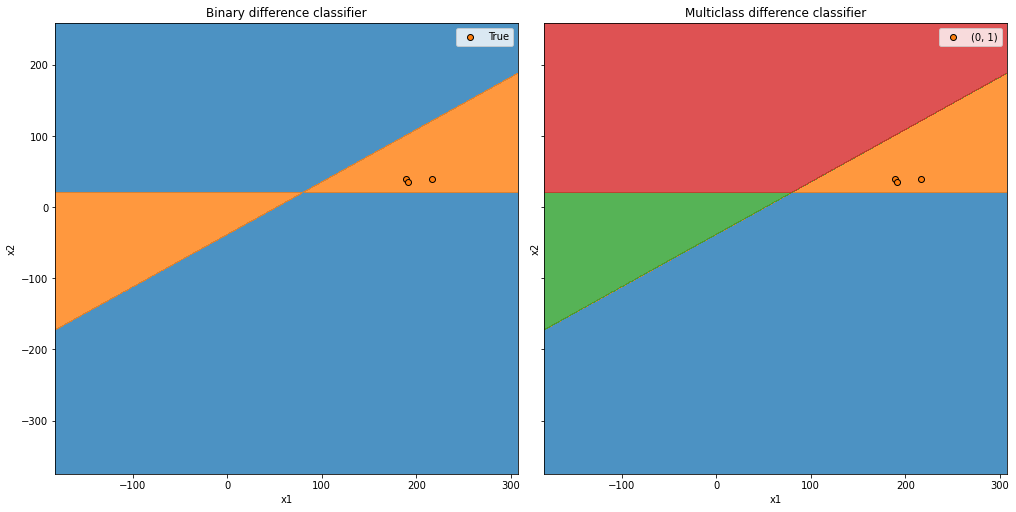

In [59]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLLR

In [38]:
node = node.root.get('RRLLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLR,
 (0, 1)    3
 dtype: int64,
 0.030314820289479016)

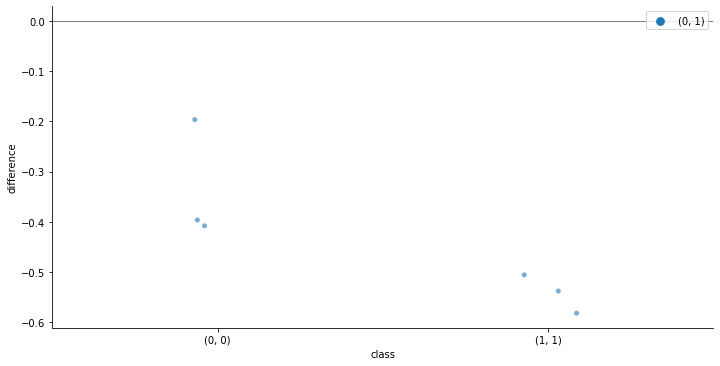

{'(0, 0)': '-0.41 to -0.2', '(1, 1)': '-0.58 to -0.51'}


In [39]:
node.plot_outcome_differences()

236.75428302388113 <= x1
x1 <= 111.0 --> {'(1, 1)': 3}


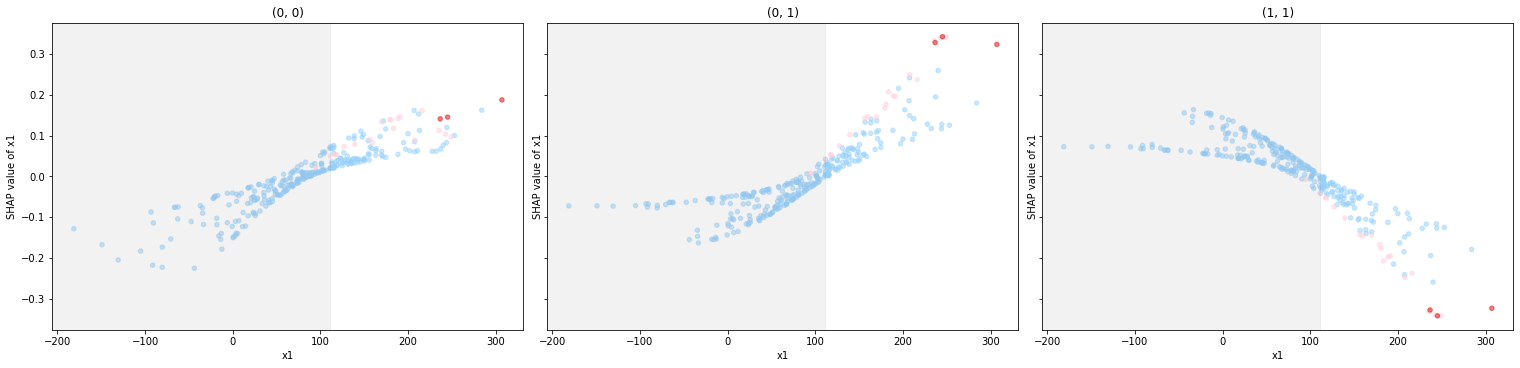

43.996255745135436 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 3}
x2 >= 189.0 --> {'(1, 1)': 3}


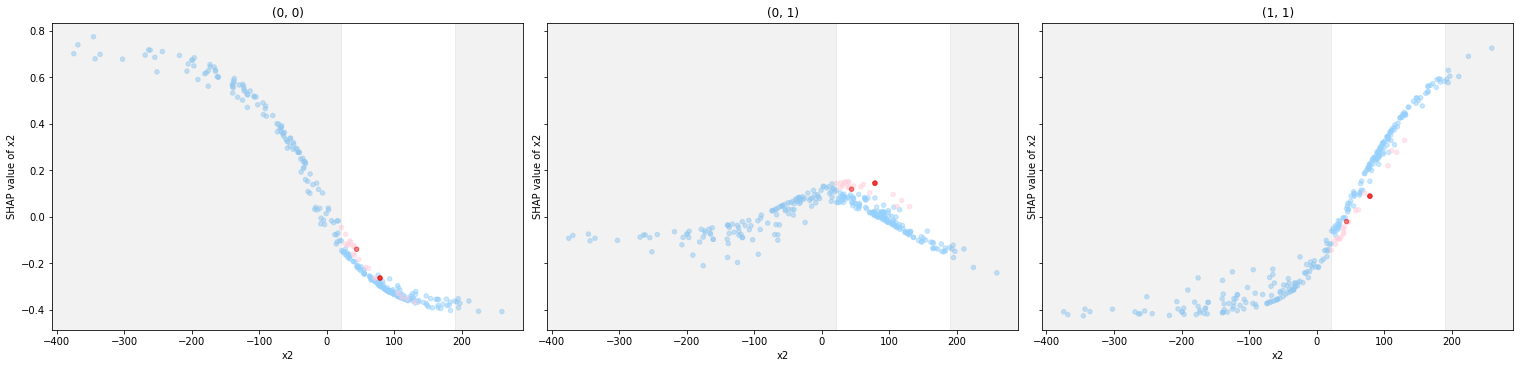

In [40]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

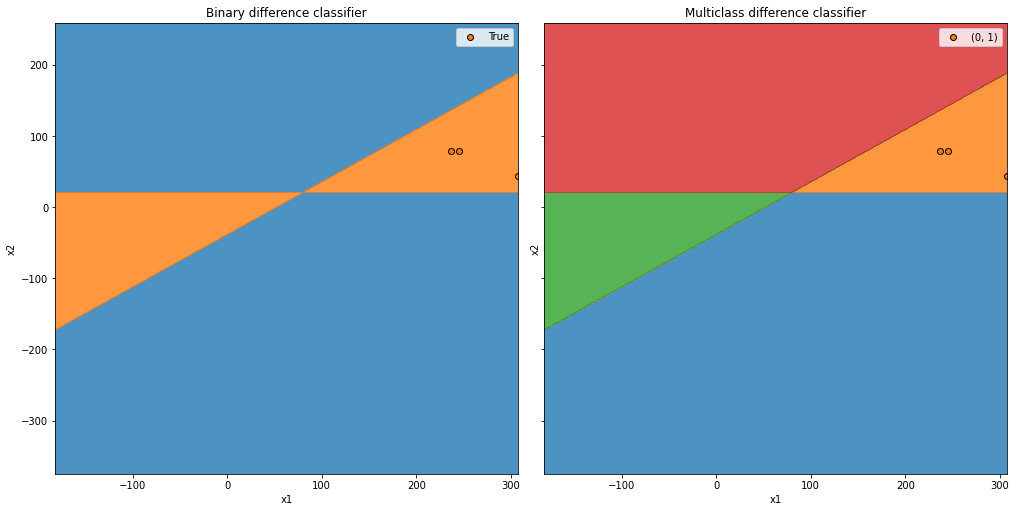

In [41]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLLRL

In [42]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLRL,
 (0, 1)    1
 dtype: int64,
 0)

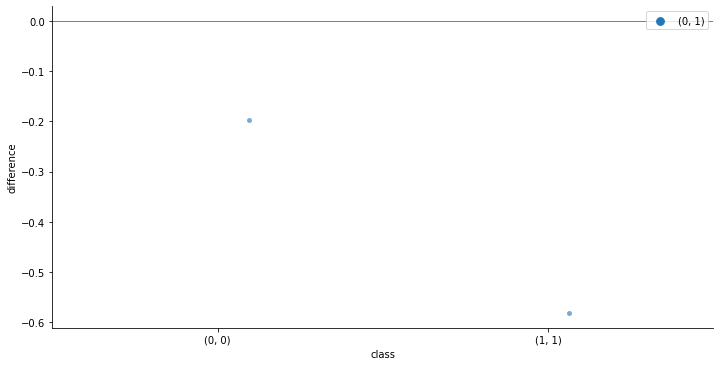

{'(0, 0)': '-0.2 to -0.2', '(1, 1)': '-0.58 to -0.58'}


In [43]:
node.plot_outcome_differences()

x1 == 307.1575256660399
x1 <= 111.0 --> {'(1, 1)': 1}


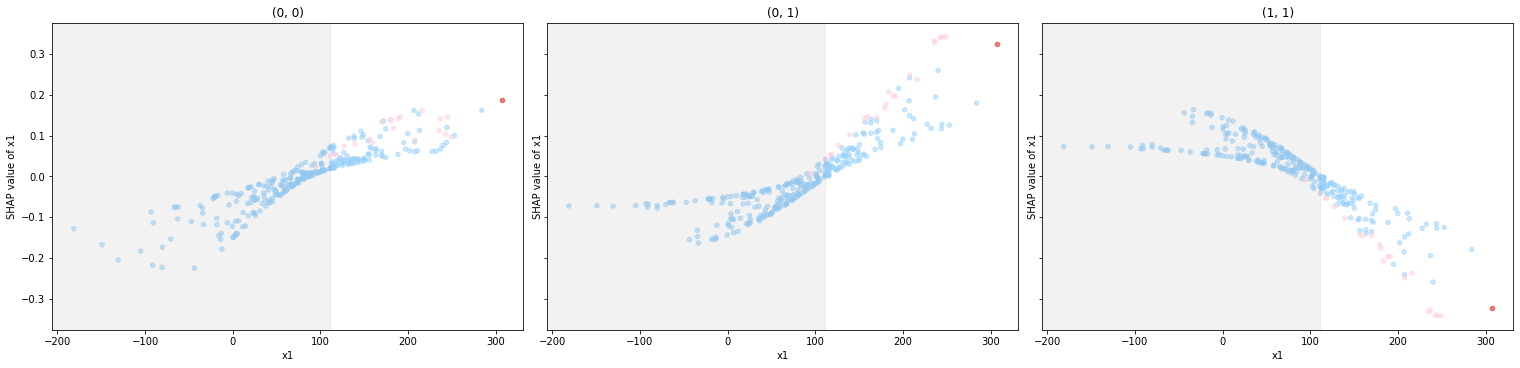

x2 == 43.996255745135436
x2 <= 21.0 --> {'(0, 0)': 1}
x2 >= 189.0 --> {'(1, 1)': 1}


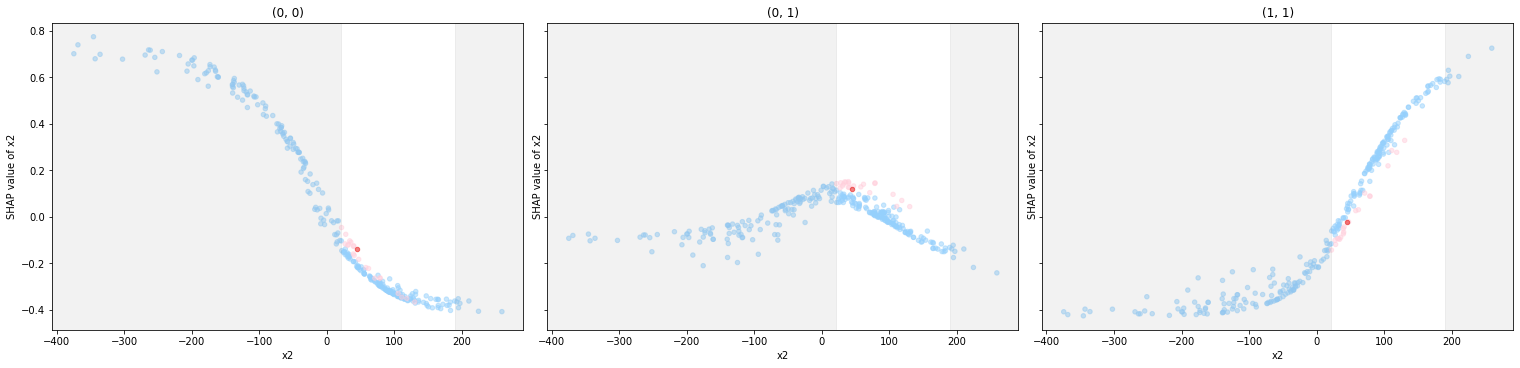

In [44]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

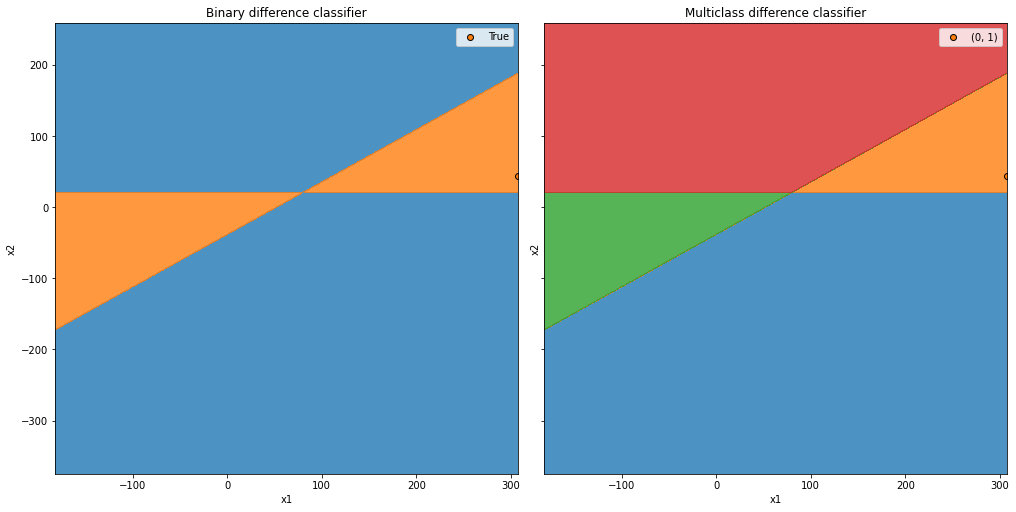

In [45]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RRLLRR

In [46]:
node = node.parent.get_right().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLLRR,
 (0, 1)    2
 dtype: int64,
 0.0004375035033801457)

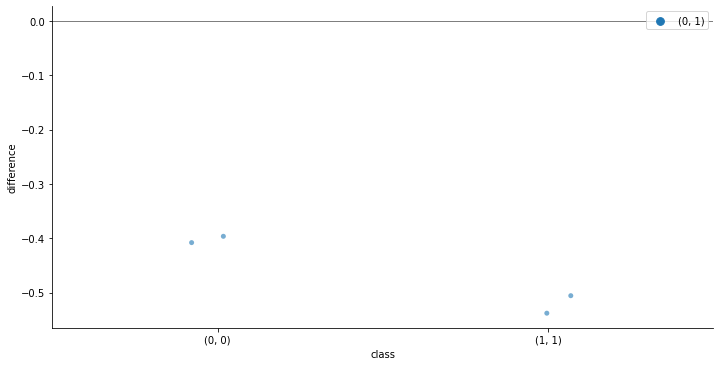

{'(0, 0)': '-0.41 to -0.4', '(1, 1)': '-0.54 to -0.51'}


In [47]:
node.plot_outcome_differences()

236.75428302388113 <= x1 <= 245.17590166375376
x1 <= 158.0 --> {'(1, 1)': 2}


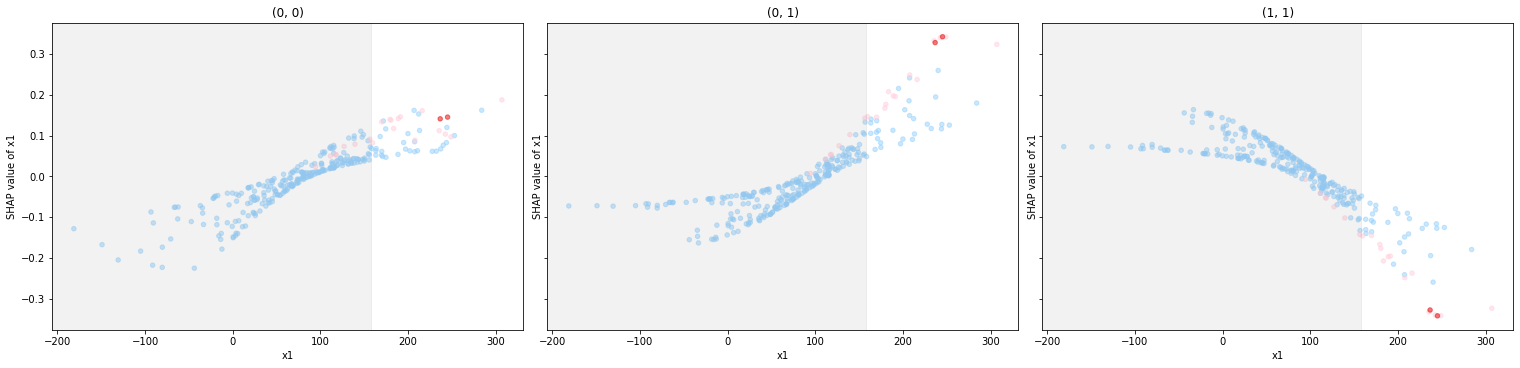

78.44525088412485 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 2}
x2 >= 143.0 --> {'(1, 1)': 2}


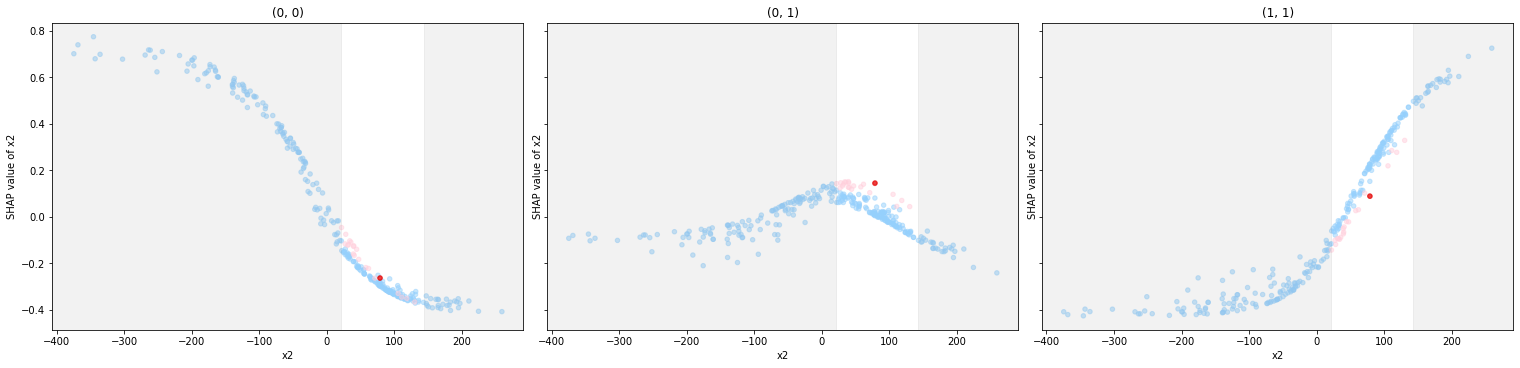

In [48]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

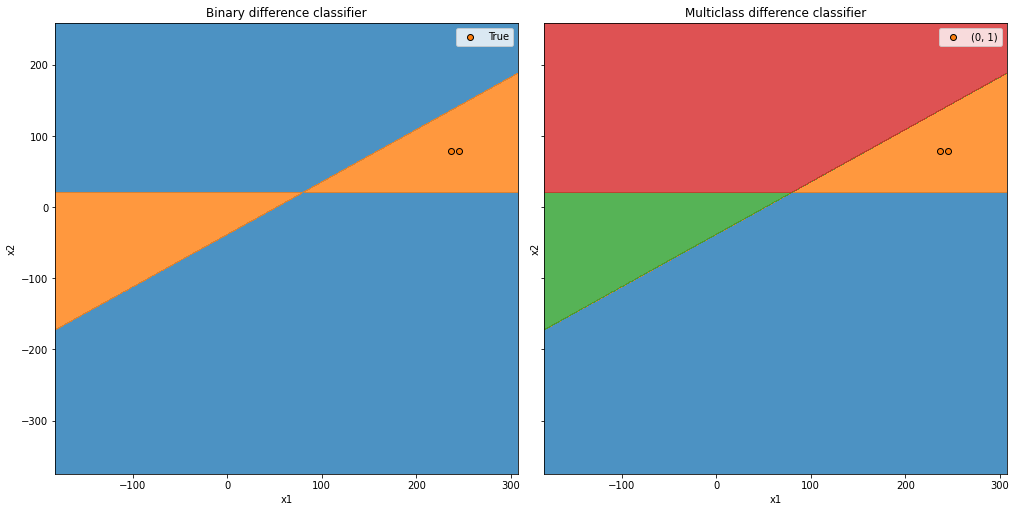

In [49]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

## Clustering of Class $(1, 0)$ SHAP Values

In [60]:
# TODO